## Hotel Arabic-Reviews Dataset

Dans ce notebook, nous allons mettre en oeuvre une analyse générale de notre base de données en s'appuyant sur les axes suivants :

* [I- Importer les bibliothèques importantes](#chapter1)
* [II- Importer les données](#chapter2)
* [III- Caractéristiques des données ](#chapter3)
    * [1- Apercu des données](#section_3_1)
    * [2- Le nombre de lignes et colonnes](#section_3_2)
    * [3- Les valeurs manquantes](#section_3_3)
    * [4- Les doublons](#section_3_4)
    * [5- Le type des variables](#section_3_5)
* [IV- Analyse de données](#chapter4)
    * [1- La distribution des sentiments](#section_4_1)
    * [2- La taille des commentaires](#section_4_2)

Après avoir pris une idée générale sur les données ainsi que les variables, nous allons attaquer une approche qui se base sur le ***Deep Learning*** et plus précisément **`Bi_LSTM`** model en se basant sur les axes suivantes :


* [V- Nettoyage de données](#chapter5)
* [VI- Diviser les données](#chapter6)
* [VII- Word2Vec](#chapter7)
    * [1- Implementer FastText](#section_7_1)
    * [2- Tokenisation](#section_7_2)
    * [3- Padding](#section_7_3)
    * [4- Construire Embedding_Matrix](#section_7_4)
* [VIII- Modèles](#chapter8)
* [IX- Evaluation](#chapter9)

Le lien correspond au téléchargement des données : [Hotel Arabic-Reviews Dataset](https://github.com/elnagara/HARD-Arabic-Dataset) 


## I- Importer les bibliothèques importantes <a class="anchor" id="chapter1"></a>

In [ ]:
'''Décommentez ceci pour installer ces bibliothèques 

!pip install gensim

'''

In [ ]:
'''Si vous utilisez Google Colab, il faut passer toujours en premier par cette commande

pip install gensim --upgrade

'''

In [36]:
import numpy as np
import pandas as pd
import time


import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import gensim
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

import itertools
from numpy import loadtxt
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

## II- Importer les données <a class="anchor" id="chapter2"></a>

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
path_data = "/content/gdrive/MyDrive/Colab Notebooks/HARD.xlsx"

HARD = pd.read_excel(path_data)

## III- Caractéristiques des données <a class="anchor" id="chapter3"></a>

Dans cette section, nous allons analyser les différentes caractéristiques des données tel que :

- Apercu des données
- Le nombre de lignes et colonnes
- Les valeurs manquantes
- Les doublons
- Le type des variables

In [5]:
data = HARD

### 1- Apercu des données <a class="anchor" id="section_3_1"></a>

In [6]:
data.head(3)

,no,Hotel name,rating,user type,room type,nights,review
0,2,فندق 72,2,مسافر منفرد,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“ممتاز”. النظافة والطاقم متعاون.
1,3,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,16,فندق 72,5,زوج,-,أقمت ليلتين,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...


### 2- Le nombre de lignes et colonnes <a class="anchor" id="section_3_2"></a>

In [7]:
print("Data contient {} lignes et {} colonnes.".format(data.shape[0], data.shape[1]))

Data contient 105698 lignes et 7 colonnes.


|***Colonne :***  | no | Hotel name | <span style="color:red">Rating</span> |  User type | Room type |  Night |  <span style="color:red">Review</span> | 
|---|---|---|---|---|---|---|---|
| |   |   |   | | | |  |

### 3- Les valeurs manquantes <a class="anchor" id="section_3_3"></a>

In [8]:
data.isnull().sum()

no            0
Hotel name    0
rating        0
user type     0
room type     0
nights        0
review        0
dtype: int64

### 4- Les doublons <a class="anchor" id="section_3_4"></a>

In [9]:
print("On a  {} doublons dans Data.".format(data.duplicated().sum()))

On a  0 doublons dans Data.


### 5- Le type des variables <a class="anchor" id="section_3_5"></a>

In [10]:
data.dtypes

no             int64
Hotel name    object
rating         int64
user type     object
room type     object
nights        object
review        object
dtype: object

|***Colonne :***  | no | Hotel name | <span style="color:red">Rating</span> |  User type | Room type |  Night |  <span style="color:red">Review</span> | 
|---|---|---|---|---|---|---|---|
|***Type :***  | int64 | Object | <span style="color:blue">int64</span> | int64 |int64 | int64 |  <span style="color:blue">Objet</span> | 

## IV- Analyse de données <a class="anchor" id="chapter4"></a>

- Nous allons définir deux fonctions de visualisation pour simplifier la tâche dans les étapes suivantes.

In [11]:
def pie(data,col):
    labels = data[col].value_counts().keys().tolist()
    n = len(labels)
    if n==2:
        colors = ['#66b3ff', '#fb3999']
    elif n==3:
        colors = ['#66b3ff', '#fb3999', '#ffcc99']
    elif n==4:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff"]
    elif n==5:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99']
    elif n==6:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99',"#db7f23"]
    
    fig1, f1 = plt.subplots()
    f1.pie(data[col].value_counts(), labels=labels, colors = colors, autopct='%1.1f%%',shadow=False, startangle=60) 
    f1.axis('equal')
    plt.tight_layout()
    plt.show()
    
def histo(data,col):
    plt.figure(figsize = (10, 8))
    sns.histplot(data=data, x=col, hue = data[col], fill=True)

### 1- La distribution des sentiments <a class="anchor" id="section_4_1"></a>

In [12]:
data.rating.value_counts(normalize = True)

2    0.363933
4    0.250241
5    0.249759
1    0.136067
Name: rating, dtype: float64

|  ***Valeurs :*** |  1 | 2 | 4  | 5  |
|---|---|---|---|---|
|  ***Pourcentage :*** | 13.6% | 36.4%  | 25%  | 25%  |

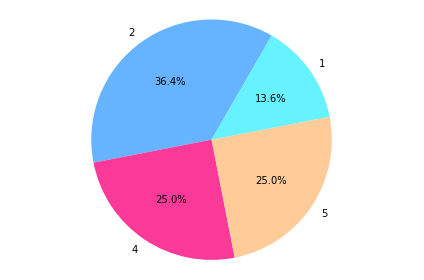

In [13]:
pie(data, "rating")

***Commentaire :***

- D'après les résultats obtenus, on peut conclure qu'on a ***une base de données équilibrée***.

Dans l'étape suivante, on va considérer que :

- Les reviews qui ont une note de 1 et 2 sont ***des reviews négatives***.
- Les reviews qui ont une note de 4 et 5 sont ***des reviews positives***.


In [14]:
positive_reviews = data[data["rating"] > 3]
positive_reviews["sentiment"] = 1

negative_reviews = data[data["rating"] < 3]
negative_reviews["sentiment"] = 0

data = pd.concat([positive_reviews, negative_reviews], ignore_index = True)

In [15]:
print("data contient {} lignes.".format(data.shape[0]))

print("Positive_reviews contient {} lignes.".format(positive_reviews.shape[0]))

print("Negative_reviews contient {} lignes.".format(negative_reviews.shape[0]))

data contient 105698 lignes.
Positive_reviews contient 52849 lignes.
Negative_reviews contient 52849 lignes.


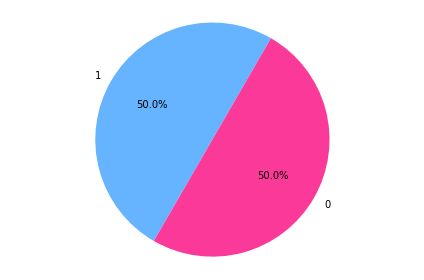

In [16]:
pie(data,"sentiment")

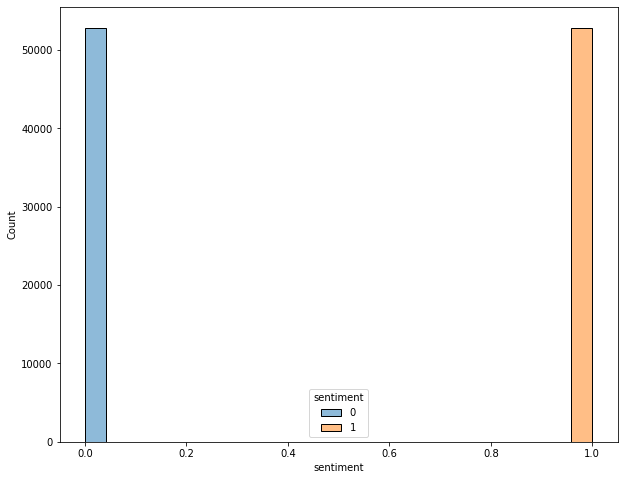

In [17]:
histo(data,"sentiment")

### 2- La taille des commentaires <a class="anchor" id="section_4_2"></a>

Dans le but d'avoir une idée générale sur le comportement des utilisateurs, la taille des commentaires peut nous donner un aperçu sur l'utilisation de la langue.

Or, même pour l'étape de la vectorisation des données, cette partie va nous donner une idée sur la taille des vecteurs et même du vocabulaire.

In [18]:
def compte_mots(phrase):
    return len(phrase.split())

data["len_review"] = data["review"].apply(compte_mots)
positive_reviews['len_review'] = positive_reviews["review"].apply(compte_mots)
negative_reviews['len_review'] = negative_reviews["review"].apply(compte_mots)

In [19]:
print("Le maximum de mots utilisé dans les reviews positives est :", max(positive_reviews.len_review))
print("Le moyen de mots utilisé dans les reviews positives est :", np.mean(positive_reviews.len_review))
print("-------------------------------------------------------------------------------------------------------")
print("Le maximum de mots utilisé dans les reviews négatives est :", max(negative_reviews.len_review))
print("Le moyen de mots utilisé dans les reviews négatives est :", np.mean(negative_reviews.len_review))

Le maximum de mots utilisé dans les reviews positives est : 570
Le moyen de mots utilisé dans les reviews positives est : 19.829703494862724
-------------------------------------------------------------------------------------------------------
Le maximum de mots utilisé dans les reviews négatives est : 614
Le moyen de mots utilisé dans les reviews négatives est : 28.094722700524134


(0.0, 200.0)

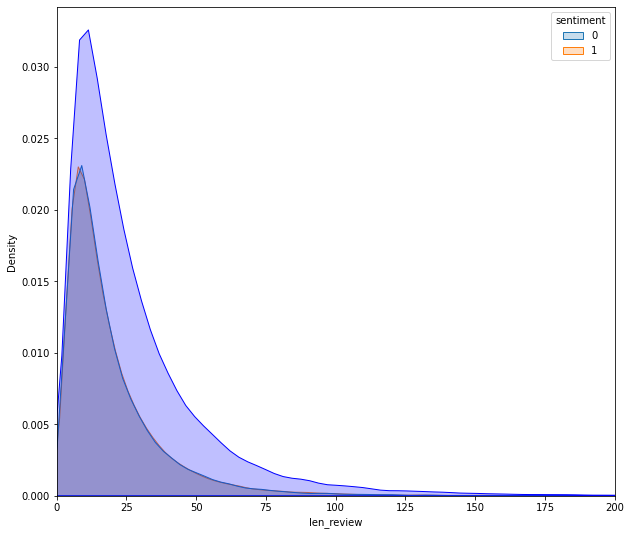

In [20]:
plt.figure(figsize=(10,9))

p1=sns.kdeplot(positive_reviews['len_review'], hue = data['sentiment'],  shade=True, color="r")
p1=sns.kdeplot(negative_reviews['len_review'], shade=True, color="b")

plt.xlim(0, 200)


***Commentaire :***

- On remarque qu'il y a le même comportement entre les utilisateurs.

***Remarque :***
- Nous allons laisser que les colonnes qui nous interessent à savoir : 
    - **sentiment** 
    - **review**

In [21]:
data.drop(['no','Hotel name','rating','user type','room type','nights'], axis = 1, inplace = True)
data.head(3)

,review,sentiment,len_review
0,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...,1,7
1,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...,1,11
2,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...,1,23


## V- Nettoyage de données <a class="anchor" id="chapter5"></a>

Les textes de tweet se composent souvent de mentions d'autres utilisateurs, de textes de liens hypertextes, d'émoticônes et de ponctuations. 

Afin de les utiliser pour notre modèle. Nous ne pouvons pas autoriser ces textes pour la formation d'un modèle. 

Nous devons donc nettoyer les données textuelles en utilisant diverses méthodes de prétraitement et de nettoyage.

Pour ne pas perdre les données initiales, nous allons les stocker dans une nouvelle variable `df`.

In [22]:
df = data

In [23]:
def preprocessing(x):
    x = re.sub('@[^\s]+', ' ', x)
    x = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',x)
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030""]+", flags=re.UNICODE)
    emoji_pattern.sub(r'', x)
    
    ar_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ#'''
    en_punctuations = string.punctuation
    punctuations = ar_punctuations + en_punctuations
    x = x.translate(str.maketrans('', '', punctuations))
 
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    x = re.sub(arabic_diacritics, '', str(x)) 
    
#     x = re.sub("[إأآا]", "ا", x)
#     x = re.sub("ى", "ي", x)
#     x = re.sub("ة", "ه", x)
#     x = re.sub("گ", "ك", x)
#     x = re.sub(r'(.)\1+', r'\1', x)
    
    return x

In [24]:
%%time
data["Clean_reviews"] = data.review.apply(lambda x: preprocessing(x))

CPU times: user 3.75 s, sys: 33.8 ms, total: 3.78 s
Wall time: 3.8 s


In [25]:
print('- Avant le prétraitement \n\n',data["review"][4])
print("\n-----------------------------------------------\n")
print('- Après le prétraitement \n\n',data["Clean_reviews"][4])

- Avant le prétraitement 

 “جيدجداً”. الافطار جيد والسرير ممتاز ومريح واطلالة الغرفة رائعه. فرش ارضية الغرفه

-----------------------------------------------

- Après le prétraitement 

 جيدجدا الافطار جيد والسرير ممتاز ومريح واطلالة الغرفة رائعه فرش ارضية الغرفه


***Remarque :***
- Nous remarquons que les données sont bien prétraités et ils sont prêts pour les utiliser.

In [26]:
# data.to_csv("cleaned_data.csv")

## VI- Diviser les données <a class="anchor" id="chapter6"></a>

- Le but de cette étape est de diviser les données en deux parties :
    - La partie d'entrainement *(Train_Set)* : **80%**
    - La partie du test *(Test_Set)* : **20%**

$$
105.698 * 80\% = 84.558
$$
$$
105.698 * 20\% = 21.140
$$

***NB :***
- Nous allons extraire une partie de *Validation* du *Train_Set*.

In [52]:
X = data.Clean_reviews
y = data.sentiment

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

In [54]:
print('Train set', X_train.shape)
print('Test set', X_test.shape)

Train set (84558,)
Test set (21140,)


## VII- Word2Vec <a class="anchor" id="chapter7"></a>

**Word Embeddings** sont essentiellement un moyen de convertir les mots en vecteurs de représentation. L'objectif est de pouvoir générer des vecteurs de représentation similaires ou proches pour des mots ayant une signification similaire.

Alors pour satisfaire cela, nous allons adopter dans notre approche ***FastText***.

Le lien correspond au téléchargement du Word Embeddings prétraité : [Aligned Vectors](https://fasttext.cc/docs/en/aligned-vectors.html) 


### 1- Implementer FastText <a class="anchor" id="section_7_1"></a>

In [ ]:
'''Décommentez ceci pour charger Word Embeddings pour la 1er fois

%%time
target_word_vec = KeyedVectors.load_word2vec_format("wiki.ar.align.vec.txt", 
                                                    binary = False)
target_word_vec.save('target_word_vec')

'''

Wall time: 2min 18s


In [30]:
%%time
target_word_vec = KeyedVectors.load("/content/gdrive/MyDrive/Colab Notebooks/target_word_vec")

CPU times: user 387 ms, sys: 584 ms, total: 971 ms
Wall time: 17.4 s


### 2- Tokenisation  <a class="anchor" id="section_7_2"></a>

A partir d'une séquence de caractères et d'une unité documentaire définie, la tokénisation consiste à la découper en morceaux, appelés tokens, en éliminant éventuellement certains caractères, comme la ponctuation. Ce processus est appelé ***tokenisation***.

In [55]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

CPU times: user 3.57 s, sys: 31 ms, total: 3.61 s
Wall time: 3.61 s


In [56]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

### 3- Padding  <a class="anchor" id="section_7_3"></a>

D'après l'analyse qui était faite au dessus, nous avons vu que le maximum de mots utilisé est environ de ***614***.

Donc nous allons prendre `maxlen = 615`.

In [57]:
%%time
MAX_SEQUENCE_LENGTH = 615

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:", X_train.shape)
print("Testing X Shape:", X_test.shape)

Training X Shape: (84558, 615)
Testing X Shape: (21140, 615)
CPU times: user 4.46 s, sys: 150 ms, total: 4.61 s
Wall time: 4.52 s


### 4- Construire Embedding_Matrix  <a class="anchor" id="section_7_4"></a>

In [58]:
%%time
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in word_index.items():
    if word in target_word_vec :
        embedding_vector = target_word_vec[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

CPU times: user 344 ms, sys: 161 ms, total: 505 ms
Wall time: 499 ms


In [59]:
embedding_matrix.shape[0] == vocab_size

True

## VIII- Modèles <a class="anchor" id="chapter8"></a>

Nous sommes prêts maintenant à construire notre modèle de Deep Learning. Lors du développement d'un modèle Deep Learning, nous devons garder à l'esprit des éléments clés à savoir : 
- L'architecture du modèle
- Le réglage de l'hyperparamètre
- Les performances du modèle

In [60]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 
                            300, 
                            weights = [embedding_matrix], 
                            input_length = MAX_SEQUENCE_LENGTH, 
                            trainable=False)
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.001), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 615, 300)          39620400  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 614, 64)           38464     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 614, 128)          66048     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 39,725,041
Trainable params: 104,641
Non-trainable params: 39,620,400
____________________________________

In [61]:
history = model.fit(X_train, y_train, validation_split=0.15, batch_size = 1024, epochs=20, verbose=1, callbacks=[es])

Epoch 1/20
71/71 [==============================] - 52s 681ms/step - loss: 0.4319 - accuracy: 0.8247 - val_loss: 0.2365 - val_accuracy: 0.9163
Epoch 2/20
71/71 [==============================] - 48s 671ms/step - loss: 0.2218 - accuracy: 0.9211 - val_loss: 0.1972 - val_accuracy: 0.9285
Epoch 3/20
71/71 [==============================] - 48s 671ms/step - loss: 0.1947 - accuracy: 0.9299 - val_loss: 0.1858 - val_accuracy: 0.9317
Epoch 4/20
71/71 [==============================] - 48s 672ms/step - loss: 0.1828 - accuracy: 0.9338 - val_loss: 0.1746 - val_accuracy: 0.9379
Epoch 5/20
71/71 [==============================] - 48s 671ms/step - loss: 0.1744 - accuracy: 0.9371 - val_loss: 0.1710 - val_accuracy: 0.9387
Epoch 6/20
71/71 [==============================] - 48s 673ms/step - loss: 0.1680 - accuracy: 0.9394 - val_loss: 0.1648 - val_accuracy: 0.9408
Epoch 7/20
71/71 [==============================] - 48s 673ms/step - loss: 0.1627 - accuracy: 0.9418 - val_loss: 0.1621 - val_accuracy: 0.9429

## IX- Evaluation <a class="anchor" id="chapter9"></a>

In [62]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

661/661 [==============================] - 59s 89ms/step - loss: 0.1544 - accuracy: 0.9452
accuracy: 94.52%


In [65]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [67]:
scores = model.predict(X_test, verbose=1)

y_pred = [decode_sentiment(x) for x in scores]

661/661 [==============================] - 57s 85ms/step


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     10600
           1       0.93      0.96      0.95     10540

    accuracy                           0.95     21140
   macro avg       0.95      0.95      0.95     21140
weighted avg       0.95      0.95      0.95     21140



In [71]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

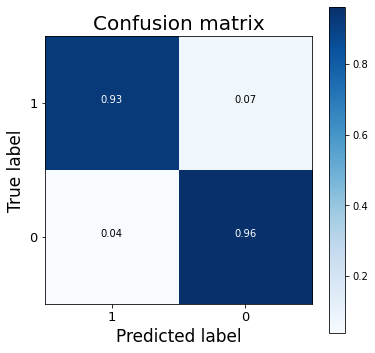

In [73]:
cnf_matrix = confusion_matrix(y_test.to_list(), y_pred)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

In [64]:
model.save("/content/gdrive/MyDrive/Colab Notebooks/model.h5")
print("Saved model to disk")

Saved model to disk


## Reference

- A Deep Learning Approach Combining CNN and Bi-LSTM with SVM Classifier for Arabic Sentiment Analysis 